In [1]:
import os
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from pathlib import Path
import urllib.request
import zipfile

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

%load_ext autoreload
%autoreload 2

# Download and extract the dataset
The dataset is downloaded from the provided URL and extracted into the 'Dataset' folder

In [2]:
# Download dataset
url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

# Create dataset folder if it doesn't exist
dataset_folder = './Dataset'
if not os.path.exists(dataset_folder):
    os.mkdir(dataset_folder)

# Download dataset if it doesn't exist
dataset_path = os.path.join(dataset_folder, 'dependency_treebank.zip')

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")    
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        print("Extracting dataset")
        zip_ref.extractall(dataset_folder+'/dependency_treebank')
    os.remove(dataset_path) # Remove zip file


Successful download
Extracting dataset


# Split the data
The data (199 samples in total) is split into a train, validation and test set:
- 100 train samples
- 50 validation samples
- 49 test samples 
The sets are stored in data frames.

In [3]:
# Define split size
TRAIN_SPLIT = 100
VAL_SPLIT = 150

# Define file iterator
def file_iterator():
    data_dir = Path('dependency_treebank')
    for data_file in filter(lambda f: os.path.isfile(data_dir/f) and f.endswith('.dp'), os.listdir(data_dir)):
        yield data_dir/data_file

# Create train, val and test set
train_set = []
test_set = []
val_set = []
file_counter = 0

# Iterate over files and perform split
for file in file_iterator():
    file_counter += 1
    if file_counter <= TRAIN_SPLIT:
        train_set.append(pd.read_csv(file, sep="\t", names=['token', 'pos'], usecols=[0, 1], engine='python'))
    elif file_counter <= VAL_SPLIT:
        val_set.append(pd.read_csv(file, sep="\t", names=['token', 'pos'], usecols=[0, 1], engine='python'))
    else:
        test_set.append(pd.read_csv(file, sep="\t", names=['token', 'pos'], usecols=[0, 1], engine='python'))

# Check for correct split
assert len(train_set) == 100
assert len(val_set) == 50
assert len(test_set) == 49

# Change to pandas dataframe
train_frame = pd.concat(train_set)
test_frame = pd.concat(test_set)
val_frame = pd.concat(val_set)

# Check for correct transformation
assert sum([e.shape[0] for e in train_set]) == train_frame.shape[0]
assert sum([e.shape[0] for e in test_set]) == test_frame.shape[0]
assert sum([e.shape[0] for e in val_set]) == val_frame.shape[0]

Check the structure of the constructed data frames

In [4]:
train_frame.head()

,token,pos
0,In,IN
1,reference,NN
2,to,TO
3,your,PRP$
4,Oct.,NNP


In [5]:
test_frame.head()

,token,pos
0,For,IN
1,six,CD
2,years,NNS
3,",",","
4,T.,NNP


In [6]:
val_frame.head()

,token,pos
0,Lord,NNP
1,Chilver,NNP
2,",",","
3,63-year-old,JJ
4,chairman,NN


# Tokenization and padding
The data frames are now tokenized and additional padded to have a unit input length 

In [7]:
# merge train_frame['token'].values and val_frame['token'].values
new_train_frame = pd.concat([train_frame, val_frame], ignore_index=True)

# create tokenizer and fit on training and val set
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_train_frame['token'].values)

# Routine to tokenize and pad data to unit length
def tokenize_and_pad(data_frame, tokenizer):
    vocab_size = len(tokenizer.word_index) + 1
    print('Vocabulary size: %d' % vocab_size)
    encoded_doc = tokenizer.texts_to_sequences(data_frame['token'].values)
    max_length = max([len(s.split()) for s in data_frame['token'].values]) # Changed max length to max length of a sentence
    padded_docs = pad_sequences(encoded_doc, maxlen=max_length, padding='post')
    return padded_docs, vocab_size, tokenizer

# train set
train_padded_docs, train_vocab_size, train_tokenizer = tokenize_and_pad(train_frame, tokenizer)

# val set
val_padded_docs, val_vocab_size, val_tokenizer = tokenize_and_pad(val_frame, tokenizer)

# test set
test_padded_docs, test_vocab_size, test_tokenizer = tokenize_and_pad(test_frame, tokenizer)

Vocabulary size: 8424
Vocabulary size: 8424
Vocabulary size: 8424


# Create embedding matrix
First, the pretrained glove-embedding has been downloaded from https://nlp.stanford.edu/projects/glove/ and converted to a dictionary format (100-dimensional embeddings).

In [8]:
embeddings_index = dict()
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        embeddings_index[values[0]] = asarray(values[1:], dtype='float32')

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


Define a function to create an embedding matrix from a given vocabulary, using the previously loaded glove-embeddings

In [9]:
def create_embedding_matrix(tokenizer, vocab_size):
    # load embedding into memory, skip first
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            # print("Not in Vocab", word)
            pass
    return embedding_matrix

# Define and train the model
## Encode the POS-labels
We also need to convert the POS labels to a numerical representation (one-hot-encoding)

In [10]:
def encode_labels(data_frame):
    # combined_frame = pd.concat([data_frame, train_val_frame], ignore_index=True)
    encoder = LabelEncoder()
    encoder.fit(new_train_frame['pos'].values)
    encoded_Y = encoder.transform(data_frame['pos'].values)
    # convert integers to dummy variables (i.e. one hot encoded) -> labels
    labels = np_utils.to_categorical(encoded_Y)
    return labels, encoder


## Define the structure and layers of the used model
Here, a sequential model is used, that receives tokens using an Embedding layer (embedding with the loaded glove-embeddings).  
The recurrent structure is implemented using a LSTM layer with 128-units

In [11]:

def create_model(vocab_size, embedding_matrix, plot_model=False, model_type='base'):
    # define model
    model = Sequential()
    
    # Input as Embeddings
    # TODO: input length?
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=1, trainable=False))

    if model_type == 'base':
        # A Bidirectional recurrent layer (LSTM units)
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128), input_shape=(None, 50)))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(45, activation='softmax'))
    elif model_type == 'gru':
        model.add(keras.layers.Bidirectional(keras.layers.GRU(units=128), input_shape=(None, 50)))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(45, activation='softmax'))
    elif model_type == 'lstm':
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128), input_shape=(None, 50)))
        model.add(keras.layers.LSTM(units=128))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(45, activation='softmax'))
    elif model_type == 'dense':
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128), input_shape=(None, 50)))
        model.add(Dense(128, activation='relu'))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(45, activation='softmax'))
    else:
        print("No model type specified")
        exit()

    #TODO: Put in train function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # model.summary()
    if plot_model:
        keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    return model
    

# run the model
def train_model(model, padded_docs, labels, val_data, epochs=15):
    # fit the model
    history = model.fit(padded_docs, labels, epochs,validation_data=val_data, verbose=1)

    # evaluate the model
    _, accuracy = model.evaluate(padded_docs, labels, verbose=1)
    print('Accuracy: %f' % (accuracy * 100))

    plot_history(history)
    return model


def predict(model, inf_frame, inf_padded_docs):
    # encode labels
    inf_labels, inf_encoder = encode_labels(inf_frame)

    # evaluate the model
    # loss, accuracy = model.evaluate(inf_padded_docs, inf_labels, verbose=1)
    full_multiclass_report(model, inf_padded_docs, inf_labels, inf_encoder.inverse_transform(np.arange(45)))

    print('Accuracy: %f' % (accuracy * 100))



Train routine using a bidirectional LSTM layern with 128 units  
Evaluate the models training progress using the validation set

Epoch 1/15
1413/1413 [==============================] - 4s 2ms/step - loss: 1.0053 - accuracy: 0.7235 - val_loss: 0.6756 - val_accuracy: 0.7878
Epoch 2/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.5853 - accuracy: 0.8114 - val_loss: 0.5962 - val_accuracy: 0.7934
Epoch 3/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.5111 - accuracy: 0.8272 - val_loss: 0.5509 - val_accuracy: 0.8113
Epoch 4/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4706 - accuracy: 0.8365 - val_loss: 0.5363 - val_accuracy: 0.8204
Epoch 5/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4457 - accuracy: 0.8424 - val_loss: 0.5304 - val_accuracy: 0.8139
Epoch 6/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4292 - accuracy: 0.8458 - val_loss: 0.5120 - val_accuracy: 0.8282
Epoch 7/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4164 - accuracy: 0.8485 - val_loss: 0.5180 - val_accuracy:

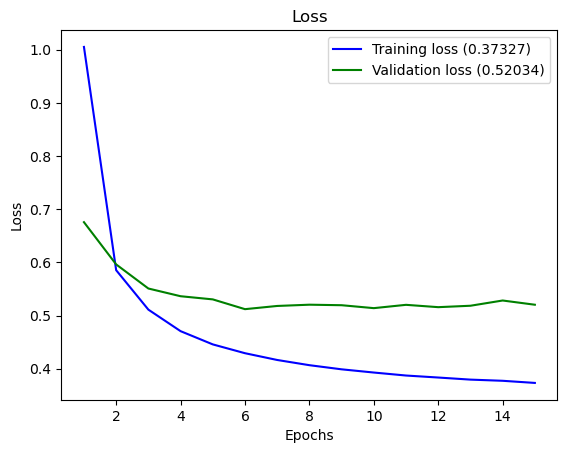

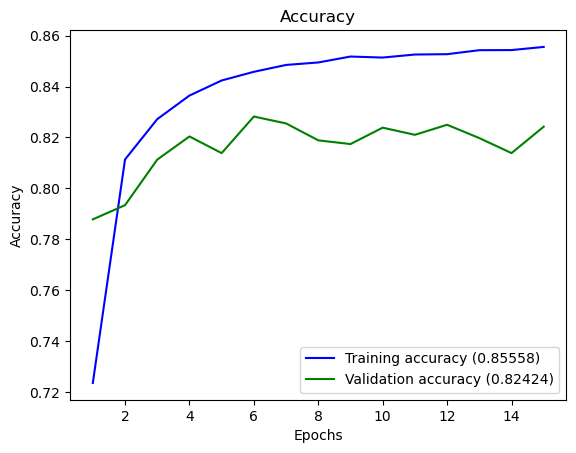

879/879 [==============================] - 1s 599us/step
Accuracy : 0.8242387592487194

[20  3  3 ... 14 22  3]
[20 20  3 ... 14 22  6]
Classification Report
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000         3
           1    0.00000   0.00000   0.00000       168
           2    1.00000   0.99127   0.99561       229
           3    0.41544   1.00000   0.58701      1410
           4    1.00000   1.00000   1.00000        40
           5    0.97561   1.00000   0.98765        40
           6    0.00000   0.00000   0.00000      1165
           7    0.00000   0.00000   0.00000       168
           8    0.99184   0.96970   0.98065       627
           9    0.97417   0.99368   0.98383       949
          10    0.98741   0.98858   0.98799      2539
          11    0.91892   1.00000   0.95775        34
          13    0.93570   0.98928   0.96175      2986
          14    0.79947   0.71127   0.75280      1704
          15    0.76190   0.494

/Users/anani/miniforge3/envs/nlp_assignment_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anani/miniforge3/envs/nlp_assignment_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anani/miniforge3/envs/nlp_assignment_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

650/650 [==============================] - 0s 625us/step
Accuracy : 0.7466178806990516

[13  9 22 ... 19 14  3]
[13  9 22 ... 20 20  6]
Classification Report
              precision    recall  f1-score   support

           1    0.00000   0.00000   0.00000       220
           2    1.00000   0.99401   0.99700       167
           3    0.26187   1.00000   0.41505      1230
           4    1.00000   1.00000   1.00000        30
           5    1.00000   1.00000   1.00000        33
           6    0.00000   0.00000   0.00000       842
           7    0.00000   0.00000   0.00000       152
           8    0.99083   0.97826   0.98450       552
           9    0.97459   0.93423   0.95398       821
          10    0.98435   0.98321   0.98378      1727
          11    0.80000   1.00000   0.88889        20
          12    0.00000   0.00000   0.00000         1
          13    0.92238   0.98744   0.95380      2070
          14    0.81373   0.63504   0.71336      1307
          15    0.86957   0.689

/Users/anani/miniforge3/envs/nlp_assignment_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anani/miniforge3/envs/nlp_assignment_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anani/miniforge3/envs/nlp_assignment_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [13]:
from utils import *

train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)
train_labels, train_encoder = encode_labels(train_frame)

print("Create embedding model...")
model = create_model(train_vocab_size, train_embedding_matrix, plot_model=True)

val_labels, val_encoder = encode_labels(val_frame)
val_data = (val_padded_docs, val_labels)

print("Fit model to train data in", 15, "epochs... ")
history = model.fit(train_padded_docs, train_labels,validation_data=val_data, epochs=15, verbose=1)
plot_history(history)

print("Print full report on validation data...")
# predict val data
full_multiclass_report(model, val_padded_docs, val_labels, val_encoder.inverse_transform(np.arange(45)))

print("Print full report on test data...")
# predict test data
test_labels, test_encoder = encode_labels(test_frame)
full_multiclass_report(model, test_padded_docs, test_labels, test_encoder.inverse_transform(np.arange(45)))

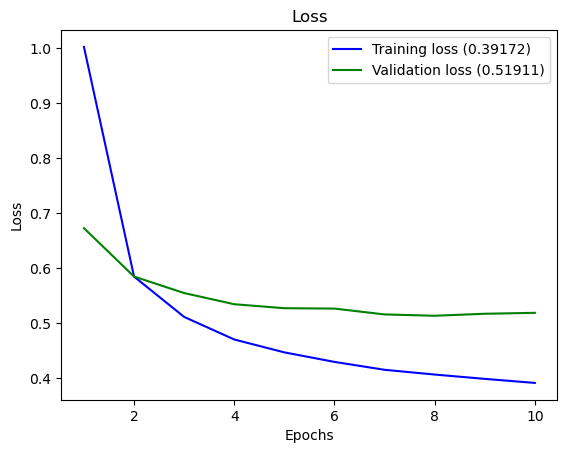

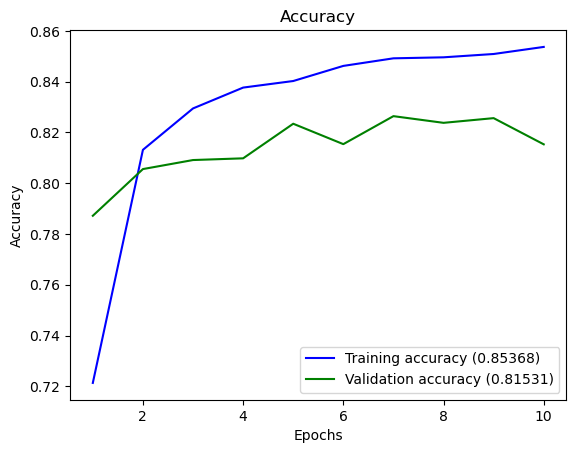

In [20]:
plot_history(history)

In [37]:
import numpy as np
# Test
test_labels, test_encoder = encode_labels(test_frame)
full_multiclass_report(model, test_padded_docs, test_labels, test_encoder.inverse_transform(np.arange(45)))

650/650 [==============================] - 0s 646us/step
Accuracy : 0.7255307881180492

[13  9 22 ... 36 14  6]
[13  9 22 ... 20 20  6]
Classification Report
              precision    recall  f1-score   support

           1    0.00000   0.00000   0.00000       220
           2    1.00000   0.99401   0.99700       167
           3    0.00000   0.00000   0.00000      1230
           4    1.00000   1.00000   1.00000        30
           5    1.00000   1.00000   1.00000        33
           6    0.17926   1.00000   0.30403       842
           7    0.00000   0.00000   0.00000       152
           8    0.98720   0.97826   0.98271       552
           9    0.97459   0.93423   0.95398       821
          10    0.98435   0.98321   0.98378      1727
          11    0.80000   1.00000   0.88889        20
          12    0.00000   0.00000   0.00000         1
          13    0.94161   0.98164   0.96121      2070
          14    0.78473   0.65264   0.71261      1307
          15    0.66667   0.931

/Users/anani/miniforge3/envs/nlp_assignment_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anani/miniforge3/envs/nlp_assignment_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anani/miniforge3/envs/nlp_assignment_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [13]:
val_labels, val_encoder = encode_labels(val_frame)
loss, accuracy = model.evaluate(val_padded_docs, val_labels, verbose=1)
print('Accuracy: %f' % (accuracy * 100))

879/879 [==============================] - 1s 662us/step - loss: 0.5235 - accuracy: 0.8271
Accuracy: 82.708454


### Baseline model

In [ ]:
train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)
train_labels, train_encoder = encode_labels(train_frame)
model = create_model(train_vocab_size, train_embedding_matrix)


TEST AREA

In [29]:
# import numpy as np
# # predict model test
# predictions = model.predict(test_padded_docs, verbose=1)
# # map predicted labels to words
# predicted_labels = []
# for i in predictions:
#     for word, index in test_tokenizer.word_index.items():
#         if index == np.argmax(i):
#             predicted_labels.append(word)
#             break
# # map actual labels to words
# actual_labels = []
# for i in test_frame['pos'].values:
#     for word, index in test_tokenizer.word_index.items():
#         if index == i:
#             actual_labels.append(word)
#             break
# # create confusion matrix
# confusion_matrix = pd.crosstab(pd.Series(actual_labels), pd.Series(predicted_labels), rownames=['Actual'], colnames=['Predicted'])

44

In [34]:
# import numpy as np
# np.argmax(val_labels[0])
# np.argmax(predictions[0])

35

In [ ]:
model = Sequential()
# Adding the input layer and the first hidden layer
model.add(Dense(16, activation = 'relu', input_dim = 243))
# Adding the output layer
model.add(Dense(units = 1))
model.compile(optimizer = 'adam',loss = 'mean_squared_error')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40) # Model stop training after 40 epoch where validation loss didnt decrease
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True) #You save model weight at the epoch where validation loss is minimal
train = model.fit((train_X, train_label, batch_size=batch_size),epochs=1000,verbose=1,validation_data=(valid_X, valid_label),callbacks=[es,mc])#you can run for 1000 epoch btw model will stop after 40 epoch without better validation loss